In [0]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dmitey","key":"600307451c04e8f81703a685862307d5"}'}

In [0]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import re

In [0]:
!pip3 install kaggle

In [0]:
!mkdir -p /root/.kaggle/
!cp kaggle.json /root/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 97% 695M/714M [00:03<00:00, 213MB/s]
100% 714M/714M [00:03<00:00, 206MB/s]


In [0]:
import zipfile
z = zipfile.ZipFile('/content/lgg-mri-segmentation.zip', 'r')
listing = z.namelist()

In [0]:
def show_mask(index):
  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
  axes[0].imshow(y[index, ..., 0])
  axes[1].imshow(X[index])

In [0]:
def extract_img(size):
  X_train = []
  y_train = []

  for i in range(size):
    j = np.random.randint(1, len(listing))

    if 'data_mask.csv' in listing[j] and 'data.csv' in  listing[j] and 'README.md' in listing[j]:
      j = np.random.randint(1, len(listing))

    if 'mask' not in listing[j]:
      person = re.findall(r'/\w+/', listing[j][::-1])[0][::-1][1:len(re.findall(r'/\w+/', listing[j][::-1])[0])-10]

      z.extract(listing[j])
      z.extract(listing[j][:len(listing[j])-4]+'_mask.tif')

      im = Image.open(listing[j])
      im = im.resize((256,256))

      im1 = Image.open(listing[j][:len(listing[j])-4]+'_mask.tif')
      im1 = im1.resize((256,256))

      if np.asarray(im1).any() == 0:
        continue
      else:
        y_train.append(np.asarray(im1))
        X_train.append(np.asarray(im))

    else:
      person = re.findall(r'/\w+/', listing[j][::-1])[0][::-1][1:len(re.findall(r'/\w+/', listing[j][::-1])[0])-10]
      
      z.extract(listing[j][:len(listing[j])-9] + '.tif')
      z.extract(listing[j])

      im = Image.open(listing[j][:len(listing[j])-9] + '.tif')
      im = im.resize((256,256))

      im1 = Image.open(listing[j])
      im1 = im1.resize((256,256))

      if np.asarray(im1).any() == 0:
        continue
      else:
        y_train.append(np.asarray(im1))
        X_train.append(np.asarray(im))

  y_train = np.expand_dims(y_train, -1)

  X_train = torch.FloatTensor(X_train)
  y_train = torch.FloatTensor(y_train)
        
  X_train /= 255.
  y_train /= 255.

  return X_train, y_train

In [0]:
X, y = extract_img(5000)

In [0]:
X.shape, y.shape

(torch.Size([1741, 256, 256, 3]), torch.Size([1741, 256, 256, 1]))

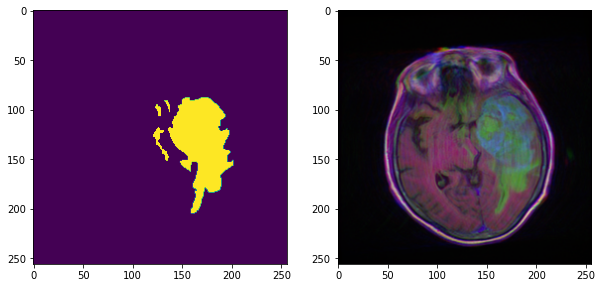

In [0]:
show_mask(5)

In [0]:
X_train = X[:int(len(X)*0.9)]
y_train = y[:int(len(y)*0.9)]

X_test = X[int(len(X)*0.9):]
y_test = y[int(len(y)*0.9):]

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

y_train = y_train.permute(0, 3, 1, 2)
y_test = y_test.permute(0, 3, 1, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
X_test.shape, y_test.shape

(torch.Size([175, 3, 256, 256]), torch.Size([175, 1, 256, 256]))

In [0]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        #Первая свертка
        self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.act1_1  = torch.nn.ReLU()
        
        self.conv1_2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.act1_2  = torch.nn.ReLU()
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Вторая свертка
        self.conv2_1 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act2_1  = torch.nn.ReLU()
        
        self.conv2_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.act2_2  = torch.nn.ReLU()
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Третья свертка
        self.conv3_1 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.act3_1  = torch.nn.ReLU()
        
        self.conv3_2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.act3_2  = torch.nn.ReLU()
        
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Четвертая свертка
        self.conv4_1 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.act4_1  = torch.nn.ReLU()
        
        self.conv4_2 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.act4_2  = torch.nn.ReLU()
        
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Апсемплинг 1
        self.up_1 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up1_1 = torch.nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.act_up1_1  = torch.nn.ReLU()
        
        self.conv_up1_2 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.act_up1_2  = torch.nn.ReLU()
        
        #Апсемплинг 2
        self.up_2 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up2_1 = torch.nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1)
        self.act_up2_1  = torch.nn.ReLU()
        
        self.conv_up2_2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.act_up2_2  = torch.nn.ReLU()
        
        #Апсемплинг 3
        self.up_3 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up3_1 = torch.nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3, padding=1)
        self.act_up3_1  = torch.nn.ReLU()
        
        self.conv_up3_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.act_up3_2  = torch.nn.ReLU()
        
        #Апсемплинг 3
        self.up_4 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up4_1 = torch.nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding=1)
        self.act_up4_1  = torch.nn.ReLU()
        
        self.conv_up4_2 = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
        self.act_up4_2  = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.act1_1(x)
        x = self.conv1_2(x)
        x, xc1 = self.act1_2(x), self.act1_2(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.act2_1(x)
        x = self.conv2_2(x)
        x, xc2 = self.act2_2(x), self.act2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.act3_1(x)
        x = self.conv3_2(x)
        x, xc3 = self.act3_2(x), self.act3_2(x)
        x = self.pool3(x)
        
        x = self.conv4_1(x)
        x = self.act4_1(x)
        x = self.conv4_2(x)
        x, xc4 = self.act4_2(x), self.act4_2(x)
        x = self.pool4(x)
        
        x, xup1 = self.up_1(x), self.up_1(x)
        conc1 = torch.cat([xc4, xup1], dim=1)
        x = self.conv_up1_1(conc1)
        x = self.act_up1_1(x)
        x = self.conv_up1_2(x)
        x = self.act_up1_2(x)
        
        x, xup2 = self.up_2(x), self.up_2(x)
        conc2 = torch.cat([xc3, xup2], dim=1)
        x = self.conv_up2_1(conc2)
        x = self.act_up2_1(x)
        x = self.conv_up2_2(x)
        x = self.act_up2_2(x)
        
        x, xup3 = self.up_3(x), self.up_3(x)
        conc3 = torch.cat([xc2, xup3], dim=1)
        x = self.conv_up3_1(conc3)
        x = self.act_up3_1(x)
        x = self.conv_up3_2(x)
        x = self.act_up3_2(x)
        
        x, xup4 = self.up_4(x), self.up_4(x)
        conc4 = torch.cat([xc1, xup4], dim=1)
        x = self.conv_up4_1(conc4)
        x = self.act_up4_1(x)
        x = self.conv_up4_2(x)
        x = self.act_up4_2(x)
        
        return x

In [0]:
def train(net, batch_size, X_train, y_train, X_test, y_test):
    loss = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    #X_test = X_test.to(device) #Перевод на девайс
    #y_test = y_test.to(device)
    X_test = X_test[:20].to(device) #Перевод на девайс
    y_test = y_test[:20].to(device)

    test_accuracy_history = []
    test_loss_history = []

    for epoch in range(25):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            net.train()
            optimizer.zero_grad() #Обнуляем градиенты
            batch_indexes = order[start_index:start_index+batch_size] #0:10, 10:20 и т.д
        
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
        
            preds = net.forward(X_batch) #предсказания
        
            loss_value = loss(preds,y_batch) #torch.squeeze
            loss_value.backward()
        
            optimizer.step()
            torch.cuda.empty_cache()

        net.eval()
        #Предсказания
        test_preds = net.forward(X_test)
        print(loss(test_preds, y_test).data.cpu())

    del net

In [0]:
def show_result(pred, index):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,10))
  axes[0].imshow(pred.permute(0,2,3,1).cpu().detach().numpy()[index, ..., 0])
  axes[1].imshow(y_test.permute(0,2,3,1).cpu().detach().numpy()[index, ..., 0])
  axes[2].imshow(X_test.permute(0,2,3,1).cpu().detach().numpy()[index, ..., ])

In [0]:
unet = UNet()
unet = unet.to(device)

In [0]:
train(unet, 16, X_train, y_train, X_test, y_test)

tensor(0.0996)
tensor(0.0554)
tensor(0.0460)
tensor(0.0492)
tensor(0.0483)
tensor(0.0516)
tensor(0.0376)
tensor(0.0318)
tensor(0.0251)
tensor(0.0419)
tensor(0.0215)
tensor(0.0210)
tensor(0.0182)
tensor(0.0247)
tensor(0.0157)
tensor(0.0154)
tensor(0.0140)
tensor(0.0125)
tensor(0.0134)
tensor(0.0112)
tensor(0.0135)
tensor(0.0120)
tensor(0.0109)
tensor(0.0119)
tensor(0.0116)


In [0]:
pred = unet.forward(X_test[:20].to(device))

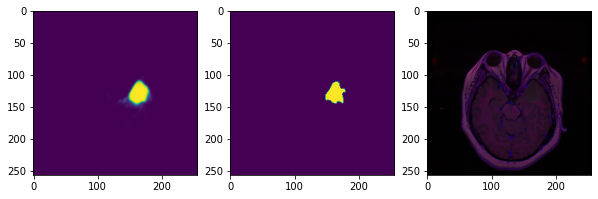

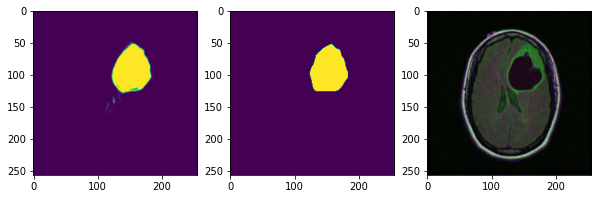

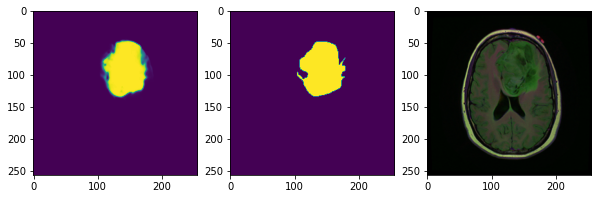

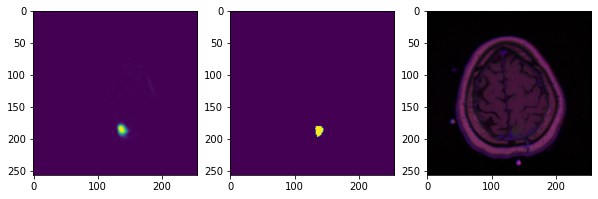

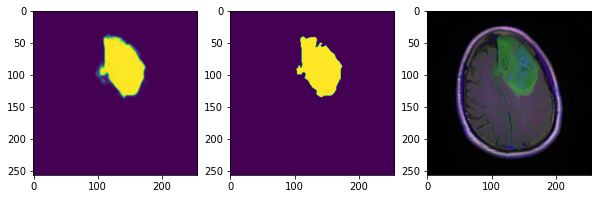

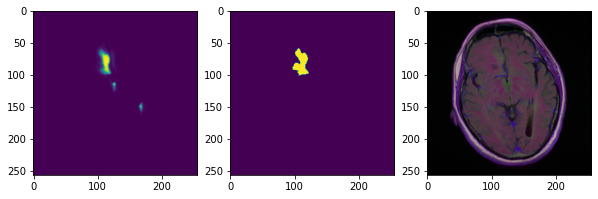

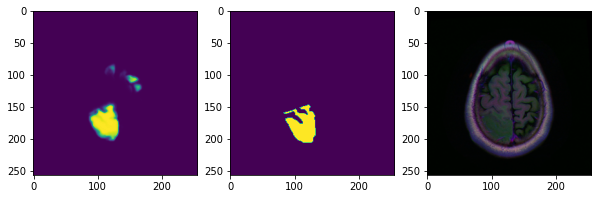

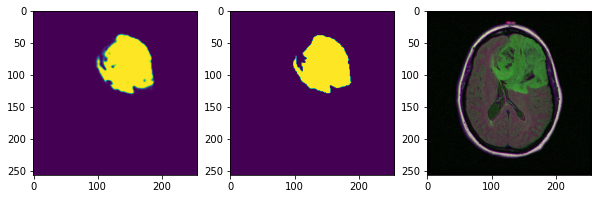

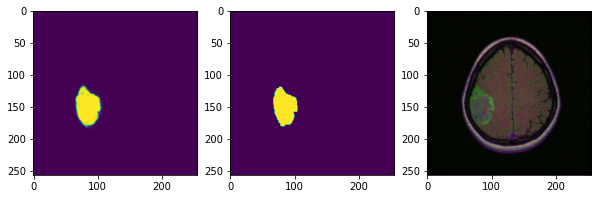

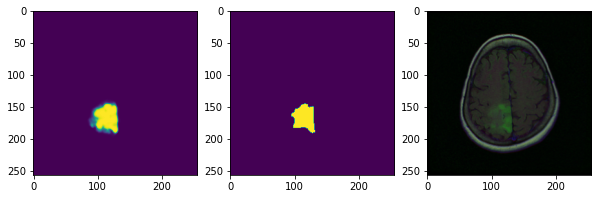

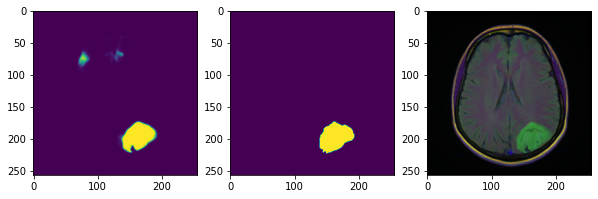

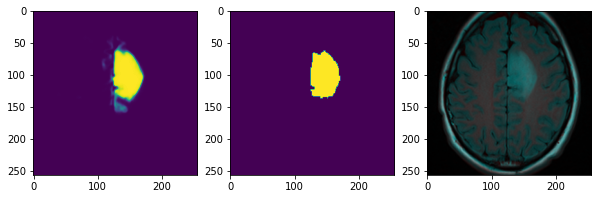

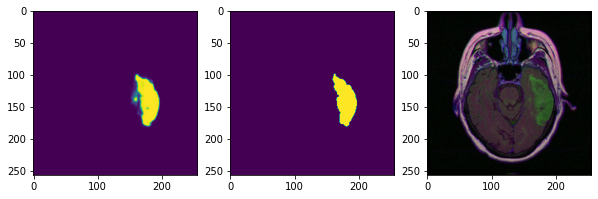

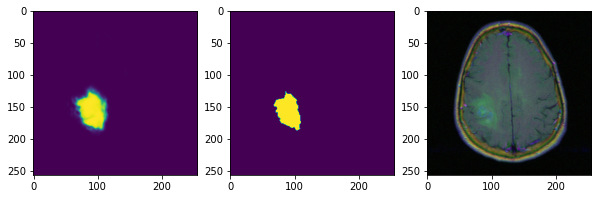

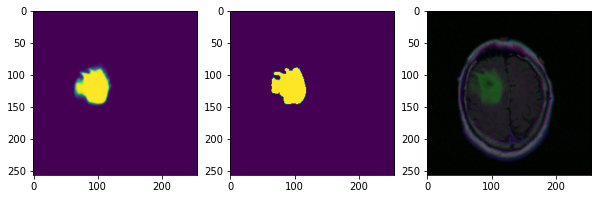

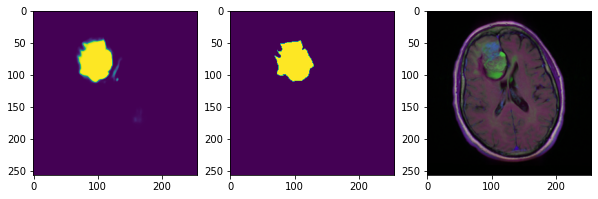

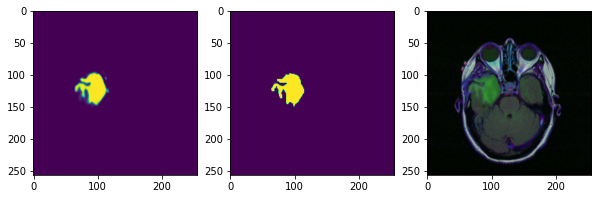

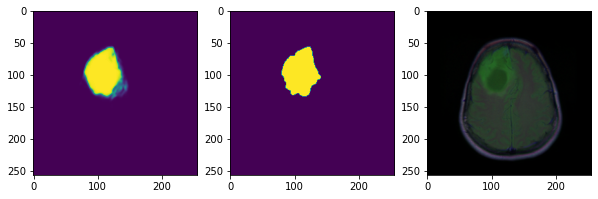

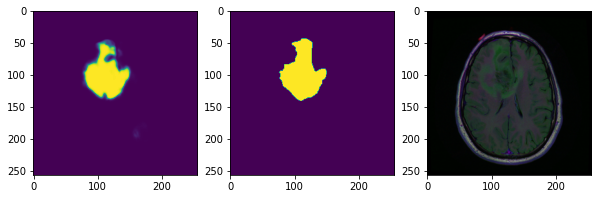

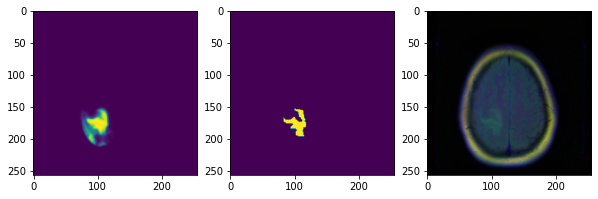

In [0]:
for i in range(20):
  show_result(pred, i)

In [0]:
X_train = []
y_train = []

for i in range(100):
  j = np.random.randint(1, len(listing))

  if 'data_mask.csv' in listing[j] and 'data.csv' in  listing[j] and 'README.md' in listing[j]:
    j = np.random.randint(1, len(listing))

  if 'mask' not in listing[j]:
    person = re.findall(r'/\w+/', listing[j][::-1])[0][::-1][1:len(re.findall(r'/\w+/', listing[j][::-1])[0])-10]

    z.extract(listing[j])
    z.extract(listing[j][:len(listing[j])-4]+'_mask.tif')

    im = Image.open(listing[j])
    im = im.resize((256,256))

    im1 = Image.open(listing[j][:len(listing[j])-4]+'_mask.tif')
    im1 = im1.resize((256,256))

    y_train.append(np.asarray(im1))
    X_train.append(np.asarray(im))

  else:
    person = re.findall(r'/\w+/', listing[j][::-1])[0][::-1][1:len(re.findall(r'/\w+/', listing[j][::-1])[0])-10]
      
    z.extract(listing[j][:len(listing[j])-9] + '.tif')
    z.extract(listing[j])

    im = Image.open(listing[j][:len(listing[j])-9] + '.tif')
    im = im.resize((256,256))

    im1 = Image.open(listing[j])
    im1 = im1.resize((256,256))

    y_train.append(np.asarray(im1))
    X_train.append(np.asarray(im))

y_train = np.expand_dims(y_train, -1)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
        
X_train /= 255.
y_train /= 255.

In [0]:
X_train = X_train.permute(0, 3, 1, 2)
y_train = y_train.permute(0, 3, 1, 2)

In [0]:
pred = unet.forward(X_train[20:40].to(device))

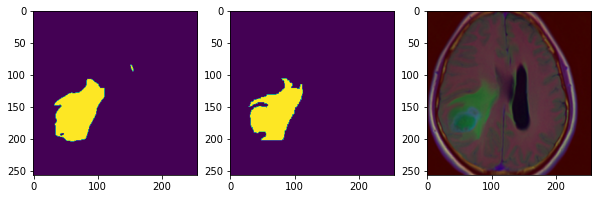

In [0]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,10))
axes[0].imshow(pred.permute(0,2,3,1).cpu().detach().numpy()[15, ..., 0] > 0.5)
axes[1].imshow(y_train.permute(0,2,3,1).cpu().detach().numpy()[20+15, ..., 0])
axes[2].imshow(X_train.permute(0,2,3,1).cpu().detach().numpy()[20+15, ..., ])